# 모형 하이퍼 파라미터 튜닝

머신 러닝 모형이 완성된 후에는 성능을 향상시키기 위한 하이퍼 파라미터 최적화 등의 모형 최적화 과정을 통해 예측 성능을 향상시킨다.

## Scikit-Learn 의 모형 하이퍼 파라미터 튜닝 도구

Scikit-Learn에서는 다음과 같은 모형 최적화 도구를 지원한다.

* [`validation_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.validation_curve.html)
  * 단일 하이퍼 파라미터 최적화
* [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)
  * 그리드를 사용한 복수 하이퍼 파라미터 최적화
* [`ParameterGrid`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.ParameterGrid.html)  
 * 복수 파라미터 최적화용 그리드


## `validation_curve` 사용 예 

`validation_curve` 함수는 최적화할 파라미터 이름과 범위, 그리고 성능 기준을 `param_name`, `param_range`, `scoring` 인수를 받아 파라미터 범위의 모든 경우에 대해 성능 기준을 계산한다.

In [1]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 10)

In [3]:
%%time
train_scores, test_scores = \
    validation_curve(SVC(), X, y,
                    param_name="gamma", param_range=param_range,
                    cv=10, scoring="accuracy", n_jobs=4)   #n_jobs 동시에 코어를 몇 개 쓸 것인지

Wall time: 15.9 s


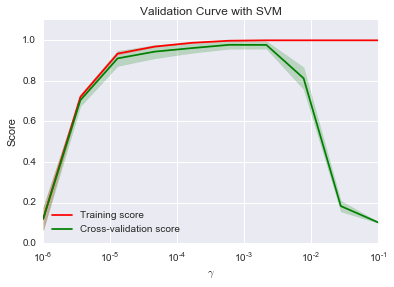

In [4]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

## `GridSearchCV` 사용예

`GridSearchCV`  클래스는 `validation_curve` 함수와 달리 모형 래퍼(Wrapper) 성격의 클래스이다.  클래스 객체에 `fit` 메서드를 호출하면 grid search를 사용하여 자동으로 복수개의 내부 모형을 생성하고 이를 모두 실행시켜서 최적 파라미터를 찾아준다. 생성된 복수개의 내부 모형과 실행 결과는 다음 속성에 저장된다.

* `grid_scores_ `
 * param_grid 의 모든 파리미터 조합에 대한 성능 결과. 각각의 원소는 다음 요소로 이루어진 튜플이다.
  * parameters: 사용된 파라미터
  * mean_validation_score: 교차 검증(cross-validation) 결과의 평균값
  * cv_validation_scores: 모든 교차 검증(cross-validation) 결과
* `best_score_` 
 * 최고 점수 
* `best_params_`
 * 최고 점수를 낸 파라미터
* `best_estimator_`
 * 최고 점수를 낸 파라미터를 가진 모형

In [6]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [7]:
pipe_svc = Pipeline([('svl', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'clf__C':param_range, 'clf__kernel': ['linear']},
    {'clf__C':param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}]   #param_name="svc__name" __언더바 2개 표시해야 한다.

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=1)
%time gs = gs.fit(X, y)

Wall time: 5min 51s


In [8]:
print(gs.best_score_)
print(gs.best_params_)

0.971619365609
{'clf__kernel': 'rbf', 'clf__C': 10.0, 'clf__gamma': 0.01}


In [9]:
gs.grid_scores_

[mean: 0.20868, std: 0.05108, params: {'clf__C': 0.0001, 'clf__kernel': 'linear'},
 mean: 0.91820, std: 0.03912, params: {'clf__C': 0.001, 'clf__kernel': 'linear'},
 mean: 0.95270, std: 0.02861, params: {'clf__C': 0.01, 'clf__kernel': 'linear'},
 mean: 0.95826, std: 0.02465, params: {'clf__C': 0.1, 'clf__kernel': 'linear'},
 mean: 0.95826, std: 0.02417, params: {'clf__C': 1.0, 'clf__kernel': 'linear'},
 mean: 0.95826, std: 0.02417, params: {'clf__C': 10.0, 'clf__kernel': 'linear'},
 mean: 0.95826, std: 0.02417, params: {'clf__C': 100.0, 'clf__kernel': 'linear'},
 mean: 0.95826, std: 0.02417, params: {'clf__C': 1000.0, 'clf__kernel': 'linear'},
 mean: 0.11909, std: 0.05244, params: {'clf__kernel': 'rbf', 'clf__C': 0.0001, 'clf__gamma': 0.0001},
 mean: 0.12020, std: 0.05576, params: {'clf__kernel': 'rbf', 'clf__C': 0.0001, 'clf__gamma': 0.001},
 mean: 0.12131, std: 0.05907, params: {'clf__kernel': 'rbf', 'clf__C': 0.0001, 'clf__gamma': 0.01},
 mean: 0.10351, std: 0.00612, params: {'clf__

## `ParameterGrid` 사용예

때로는 scikit-learn 이 제공하는 GridSearchCV 이외의 방법으로 그리드 탐색을 해야하는 경우도 있다. 이 경우 파라미터를 조합하여 탐색 그리드를 생성해 주는 명령어가 `ParameterGrid` 이다. `ParameterGrid` 는 탐색을 위한 iterator 역할을 한다. 리스트로 결과값이 나온다.

In [7]:
from sklearn.grid_search import ParameterGrid

In [8]:
param_grid = {'a': [1, 2], 'b': [True, False]}
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True},
 {'a': 1, 'b': False},
 {'a': 2, 'b': True},
 {'a': 2, 'b': False}]

In [9]:
param_grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
list(ParameterGrid(param_grid))

[{'kernel': 'linear'},
 {'gamma': 1, 'kernel': 'rbf'},
 {'gamma': 10, 'kernel': 'rbf'}]